# Packages and Data

In [1]:
import numpy as np
from numpy import linalg
from scipy.sparse import linalg as sparla
import seaborn as sns
from sklearn import svm, metrics, inspection
import cvxpy as cp

<AxesSubplot:>

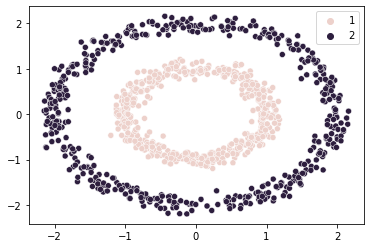

In [2]:
n = 1000
label = np.random.choice([1, 2], n)
d = np.random.normal(label, 0.1)

# setting angles up to 2*pi would create a circle
r = np.random.uniform(0, 2*np.pi, n)

# specifying 90 degrees would create a quarter of circle
# r = np.random.uniform(0, np.pi/3 + np.pi, n)

x1 = d*np.cos(r)
x2 = d*np.sin(r)
sns.scatterplot(x=x1, y=x2, hue=label)

In [3]:
X = np.column_stack([x1, x2])
Y = np.where(label==label[0], 1, -1)
X.shape, Y.shape

((1000, 2), (1000,))

# Linear and RBF Kernel

[[248 265]
 [148 339]]


<AxesSubplot:>

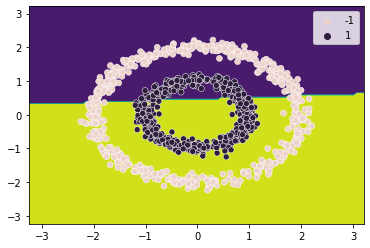

In [4]:
model = svm.SVC(kernel='linear')
model.fit(X, Y)
Z = model.predict(X)

print( metrics.confusion_matrix(Y, Z) )

inspection.DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
)

sns.scatterplot(x=x1, y=x2, hue=Y)

[[513   0]
 [  0 487]]


<AxesSubplot:>

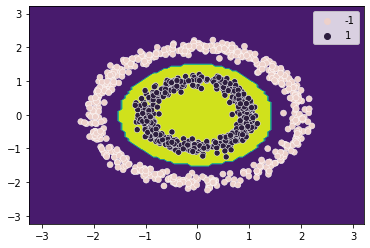

In [5]:
model = svm.SVC(kernel='rbf')
model.fit(X, Y)
Z = model.predict(X)

print( metrics.confusion_matrix(Y, Z) )

inspection.DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
)

sns.scatterplot(x=x1, y=x2, hue=Y)

# Primal Optimization

![](svm.png)

In [6]:
# function for making my own SVM function
class SVC_Primal:
    def __init__(self, C=1):
        self.C = C
    def fit(self, X, Y):
        n, p = X.shape
        E = cp.Variable(n)
        W = cp.Variable(p)
        Objective = cp.Minimize(0.5*cp.sum_squares(W) + self.C*cp.sum(E))
        Constraints = [
            E >= 1 - cp.multiply(Y, cp.matmul(X, W)),
            E >= 0,
        ]
        Problem = cp.Problem(Objective, Constraints)
        Problem.solve(solver='MOSEK')
        self.W_ = W.value
    def predict(self, X):
        Y = np.matmul(X, self.W_)
        return np.where( Y >= 0, 1, -1 )

[[280 233]
 [218 269]]


<AxesSubplot:>

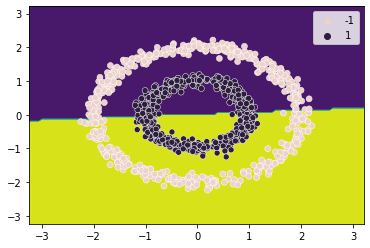

In [7]:
model_primal = SVC_Primal()
model_primal.fit(X, Y)
Z = model_primal.predict(X)

print( metrics.confusion_matrix(Y, Z) )

inspection.DecisionBoundaryDisplay.from_estimator(
        model_primal,
        X,
        response_method="predict",
)
sns.scatterplot(x=x1, y=x2, hue=Y)

Note that the decision boundary passes through the origin here. But not for the Sklearn SVM function as it uses an intercept `b`.

# Dual Optimization

Please follow the above examples to implement the SVM dual optimization

![](SVM_Dual.png)

We need to save the data and its kernel for prediction.

In [4]:
# function for dual formulation of SVM
class SVC_Dual:
    def __init__(self, kernel, C = 1):
        self.C = C
        self.kernel = kernel
    
    def fit(self, X, Y):
        self.X_ = X
        self.Y_ = Y

        #it could also be self.kernel(X, self.X_) as self.X_ = X
        # Also assume that self.kernel() returns a matrix
        K = self.kernel(X, X)
        K = np.multiply(K, Y[:, None])
        K = np.multiply(K, Y[None, :])

        # tell cvxpy that's its close enough to zero
        K = cp.atoms.affine.wraps.psd_wrapper(K, 1e-6)

        # lambda
        n, p = X.shape
        L = cp.Variable(n)

        # objective function
        # Objective = cp.Minimize(-0.5*cp.quad_form(L, K) + cp.sum(L)) #-- this is also acceptable
        Objective = cp.Maximize(0.5*cp.quad_form(L, K) - cp.sum(L))

        # constraints
        Constraints = [
            L >= 0,
            L <= self.C,
        ]

        # solve the problem
        Problem = cp.Problem(Objective, Constraints)
        Problem.solve(solver='MOSEK')
        self.L_ = L.value

    def predict(self, X):
        K = self.kernel(X, self.X_)
        K = np.multiply(K, self.Y_[None, :])
        Y = np.matmul(K, self.L_)

        # sir's method
        # K = self.kernel(X, self.X_)
        # Y = np.matmul(K, Y*self.L_)

        return np.where( Y >= 0, 1, -1 )


In [6]:
K = metrics.pairwise.rbf_kernel(X, X)
K

array([[1.00000000e+00, 9.16071888e-01, 6.10885814e-01, ...,
        3.04524996e-01, 2.32087839e-01, 1.43258652e-02],
       [9.16071888e-01, 1.00000000e+00, 8.25926257e-01, ...,
        4.87865960e-01, 4.34601730e-01, 1.45191417e-02],
       [6.10885814e-01, 8.25926257e-01, 1.00000000e+00, ...,
        4.91702156e-01, 7.11693078e-01, 3.01328130e-02],
       ...,
       [3.04524996e-01, 4.87865960e-01, 4.91702156e-01, ...,
        1.00000000e+00, 6.52007990e-01, 6.39774913e-04],
       [2.32087839e-01, 4.34601730e-01, 7.11693078e-01, ...,
        6.52007990e-01, 1.00000000e+00, 6.23295014e-03],
       [1.43258652e-02, 1.45191417e-02, 3.01328130e-02, ...,
        6.39774913e-04, 6.23295014e-03, 1.00000000e+00]])

In [7]:
linalg.eigvalsh(K)

array([-5.76079999e-14, -5.18845641e-14, -3.63927840e-14, -2.42006701e-14,
       -1.88829502e-14, -1.81350770e-14, -1.66377046e-14, -1.32360881e-14,
       -1.07135129e-14, -9.35861524e-15, -8.78411834e-15, -8.11296620e-15,
       -7.32099171e-15, -5.77485899e-15, -4.35597888e-15, -4.22766344e-15,
       -4.06004697e-15, -3.99504929e-15, -3.94660531e-15, -3.90680208e-15,
       -3.82909149e-15, -3.80242476e-15, -3.76550706e-15, -3.74481227e-15,
       -3.67695965e-15, -3.63740943e-15, -3.62873479e-15, -3.59631828e-15,
       -3.57988989e-15, -3.57286504e-15, -3.56129912e-15, -3.51685905e-15,
       -3.50626701e-15, -3.48893981e-15, -3.45828967e-15, -3.43847054e-15,
       -3.42159196e-15, -3.39798868e-15, -3.37616915e-15, -3.36145892e-15,
       -3.34209721e-15, -3.33415714e-15, -3.32254020e-15, -3.30267660e-15,
       -3.29592099e-15, -3.27405091e-15, -3.24011862e-15, -3.22211505e-15,
       -3.19902931e-15, -3.17242267e-15, -3.15820902e-15, -3.15154972e-15,
       -3.13799690e-15, -

In [8]:
K = np.multiply(K, Y[:, None])
K 

array([[ 1.00000000e+00,  9.16071888e-01,  6.10885814e-01, ...,
         3.04524996e-01,  2.32087839e-01,  1.43258652e-02],
       [ 9.16071888e-01,  1.00000000e+00,  8.25926257e-01, ...,
         4.87865960e-01,  4.34601730e-01,  1.45191417e-02],
       [ 6.10885814e-01,  8.25926257e-01,  1.00000000e+00, ...,
         4.91702156e-01,  7.11693078e-01,  3.01328130e-02],
       ...,
       [-3.04524996e-01, -4.87865960e-01, -4.91702156e-01, ...,
        -1.00000000e+00, -6.52007990e-01, -6.39774913e-04],
       [-2.32087839e-01, -4.34601730e-01, -7.11693078e-01, ...,
        -6.52007990e-01, -1.00000000e+00, -6.23295014e-03],
       [-1.43258652e-02, -1.45191417e-02, -3.01328130e-02, ...,
        -6.39774913e-04, -6.23295014e-03, -1.00000000e+00]])

In [5]:
model_dual = SVC_Dual(kernel=metrics.pairwise.rbf_kernel)
model_dual.fit(X, Y)
Z = model_dual.predict(X)

print(metrics.confusion_matrix(Y, Z))

inspection.DecisionBoundaryDisplay.from_estimator(
        model_dual,
        X,
        response_method="predict"
)
sns.scatterplot(x=x1, y=x2, hue=Y)

ArpackNoConvergence: ARPACK error -1: No convergence (10001 iterations, 0/1 eigenvectors converged)

# Appendix: Python Learnings

In [8]:
# new vector
# this is the way to initialise a np vector like a mathematical vector with one dimension 1
x = np.array([1, 2, 3])
x[:, None]

array([[1],
       [2],
       [3]])

In [10]:
x.transpose()

array([1, 2, 3])

In [12]:
x.transpose().shape

(3,)

In [13]:
x[:, None].shape

(3, 1)